In [39]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

filename = 'C://Users/Tim/Downloads/GOOG.csv'

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataDF = pd.read_csv(filename, index_col='Date', parse_dates=['Date'], date_parser=dateparse)

In [107]:
dataDF = dataDF.iloc[dataDF.index.year < 2020]

In [108]:
dataDF.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

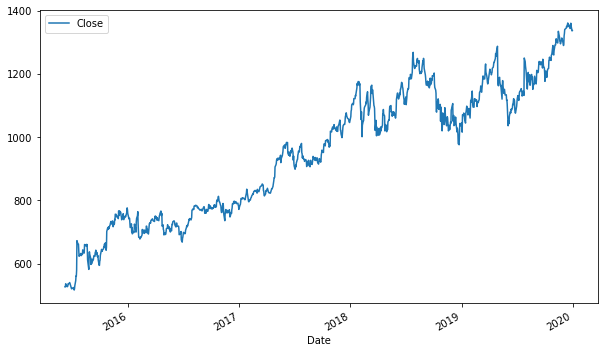

In [109]:
y_name = 'Close'
dataDF.plot(y = 'Close')

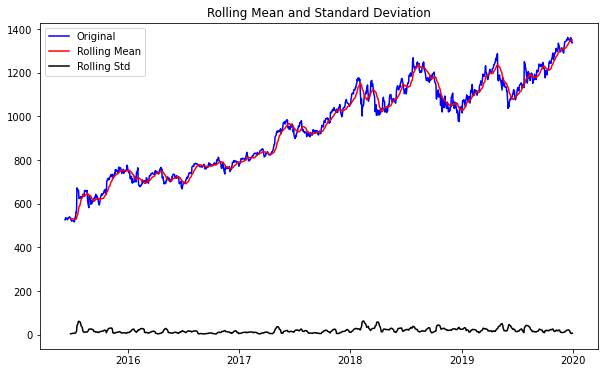

Results of dickey fuller test
Test Statistics                  -0.967196
p-value                           0.765040
No. of lags used                 11.000000
Number of observations used    1139.000000
critical value (1%)              -3.436104
critical value (5%)              -2.864081
critical value (10%)             -2.568123
dtype: float64


In [110]:
#Test for stationarity
def test_stationarity(timeseries, num):
    #Determing rolling statistics
    rolmean = timeseries.rolling(num).mean()
    rolstd = timeseries.rolling(num).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
df_close = dataDF['Close']
test_stationarity(df_close, 15)

<Figure size 720x432 with 0 Axes>

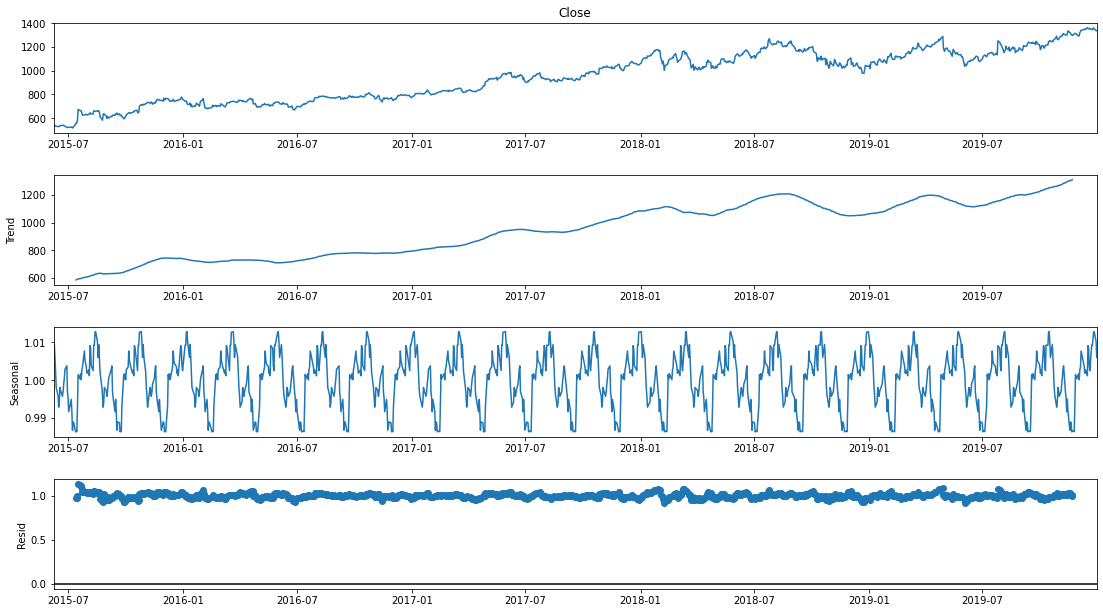

In [131]:
#result = seasonal_decompose(df_close, model='multiplicative', freq = 30)

result = seasonal_decompose(df_close, model='multiplicative', freq = 50)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

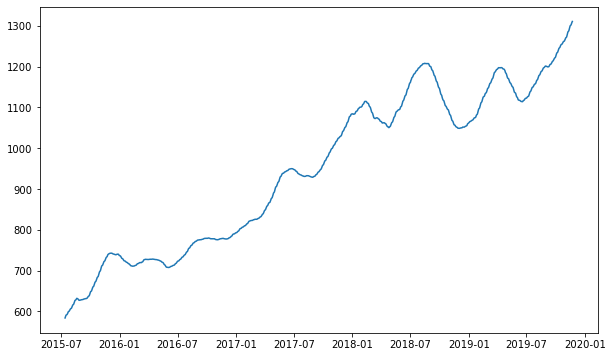

In [132]:
trend = result.trend.dropna()
trend
plt.plot(trend)

In [133]:
trend[:100]

Date
2015-07-14    583.961602
2015-07-15    586.596702
2015-07-16    589.040203
2015-07-17    590.920303
2015-07-20    592.271802
                 ...    
2015-11-25    738.670700
2015-11-27    740.570901
2015-11-30    741.895001
2015-12-01    742.447301
2015-12-02    742.643201
Name: trend, Length: 100, dtype: float64

No handles with labels found to put in legend.


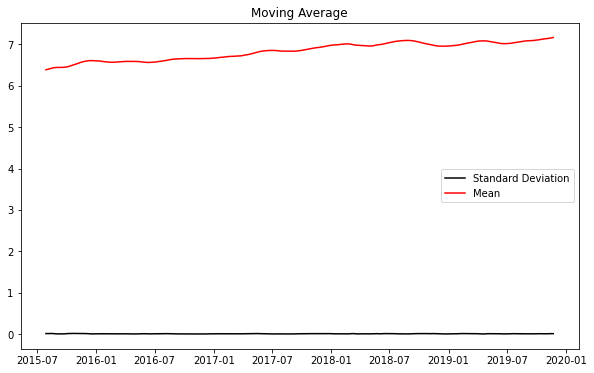

In [134]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(trend) #trend #np.log(trend)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

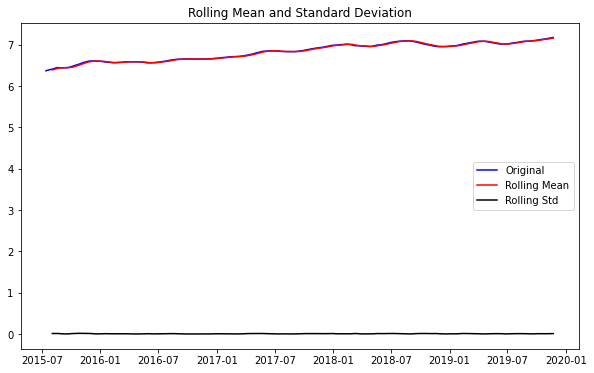

Results of dickey fuller test
Test Statistics                  -0.838381
p-value                           0.807587
No. of lags used                 20.000000
Number of observations used    1080.000000
critical value (1%)              -3.436419
critical value (5%)              -2.864220
critical value (10%)             -2.568197
dtype: float64


In [135]:
test_stationarity(df_log, 15)

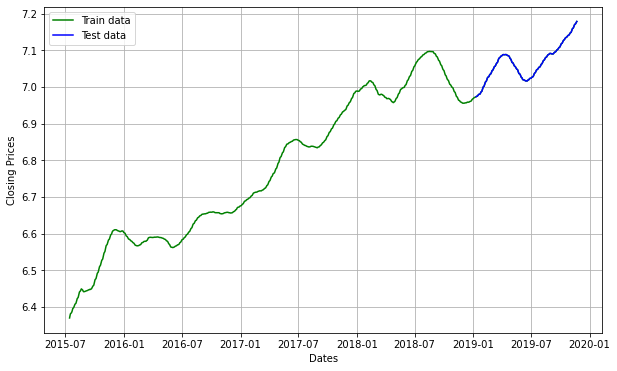

In [216]:
#split data into train and training set
part = 0.80
train_data, test_data = df_log[3:int(len(df_log)*part)], df_log[int(len(df_log)*part):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [217]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(3, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.trend   No. Observations:                  876
Model:                 ARIMA(3, 1, 1)   Log Likelihood                6165.585
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 03 Aug 2020   AIC                         -12319.170
Time:                        20:52:57   BIC                         -12290.517
Sample:                             1   HQIC                        -12308.210
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.960      0.050    5.97e-08       0.001
ar.L1.D.trend     1.0328      0.034     30.538      0.000       0.967       1.099
ar.L2.D.trend    -0.0929      0.049     

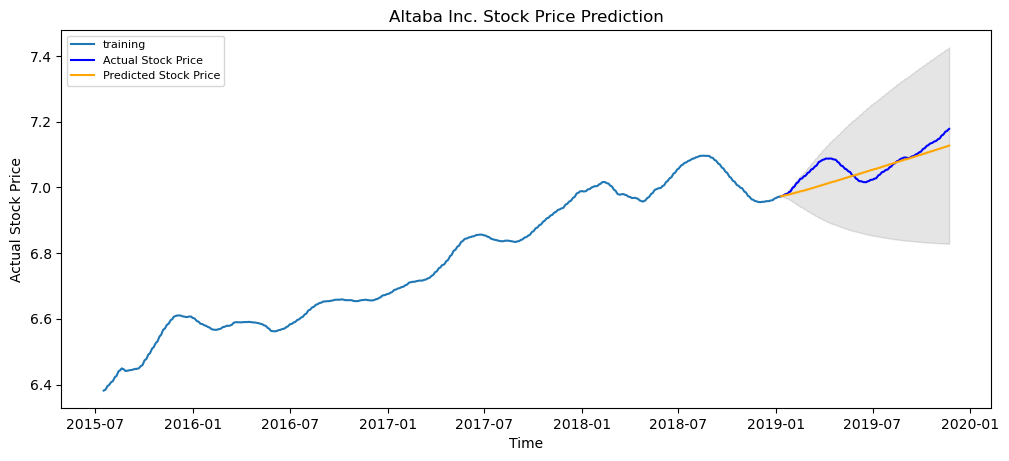

In [218]:
# Forecast
fc, se, conf = fitted.forecast(len(test_data.index), alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0013371331596936688
MAE: 0.02877677326405901
RMSE: 0.03656683141446178
MAPE: 0.004067386715431489


In [221]:
zip(fc, test_data)

In [224]:
pd.DataFrame([[a,b] for a in fc for b in test_data], columns = ['fc', 'test'])

,fc,test
0,6.973522,6.973335
1,6.973522,6.974037
2,6.973522,6.975092
3,6.973522,6.976078
4,6.973522,6.977302
...,...,...
48836,7.127787,7.172096
48837,7.127787,7.173966
48838,7.127787,7.175693
48839,7.127787,7.177156
